In [2]:
import os, json
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

%matplotlib inline

# Blending models

## Load data and make test data
- Train level 0 xgb models on 80% of data
- Train the blender on the outputs of the model
- Then validate the blended model on the remaining 20%

In [3]:
train_dat = pd.read_csv('features/zeros_ones_train.csv')
test_dat = pd.read_csv('features/zeros_ones_test.csv')
train_labels = np.load('features/train_labels.npy')

In [4]:
train_dat.head()

,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,...,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,Year,Month,Weekday,NumZero,NumMinusOne
0,1,23,0.9403,0.0006,7,1.0200,0,17,23,17,...,18,-1,10,1,0,2013,8,4,61,15
1,5,7,1.0006,0.0040,4,1.2433,0,6,8,6,...,17,-1,20,1,2,2014,4,1,66,15
2,5,7,1.0006,0.0040,4,1.2433,0,7,12,7,...,11,-1,8,1,2,2014,8,0,65,15
3,6,10,0.9769,0.0004,1,1.2665,0,3,2,3,...,9,-1,21,1,3,2013,4,0,65,17
4,4,23,0.9472,0.0006,3,1.3045,0,8,13,8,...,11,-1,12,1,1,2014,1,5,59,12


In [5]:
# Set aside a bit of data to test the blender on
dev_cutoff = int(len(train_labels)*0.80)
X_dev = train_dat[:dev_cutoff]
Y_dev = train_labels[:dev_cutoff]
X_test = train_dat[dev_cutoff:]
Y_test = train_labels[dev_cutoff:]

## Generate models

In [7]:
nmodels = 10
bag_ratio = 1.0
models = []

xg_test = xgb.DMatrix( X_test.as_matrix(), label=Y_test)

model_name = '75bag_newparam'
param = {   'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'nthread':4,
            'max_depth':6,
            'colsample_bytree':0.75, #0.77,
            'subsample':0.83,
            'eta':0.020 #0.023,
        }

num_round = 1250

for i in range(nmodels):
    print('\rModel {} of {}'.format(i+1,nmodels),end='')
    r = np.random.rand(X_dev.shape[0])
    X_bag = X_dev[r<bag_ratio]
    Y_bag = Y_dev[r<bag_ratio]
    xg_train = xgb.DMatrix( X_bag.as_matrix(), label=Y_bag)
    
    evals = {}
    watchlist = [(xg_train,'train'), (xg_test,'test')]
    model = xgb.train(param, xg_train, num_round, watchlist, evals_result=evals,
                      early_stopping_rounds=100)
    model.save_model('blend_models/{}_{}.model'.format(model_name, str(i+1).zfill(3)))
    with open('blend_models/{}_{}.eval'.format(model_name, str(i+1).zfill(3)),'w+') as f:
        json.dump(evals, f)
    models.append(model)

Will train until test error hasn't decreased in 100 rounds.
[0]	train-auc:0.924188	test-auc:0.922882
[1]	train-auc:0.932663	test-auc:0.931295
[2]	train-auc:0.940865	test-auc:0.941601
[3]	train-auc:0.941351	test-auc:0.940835
[4]	train-auc:0.942768	test-auc:0.942554
[5]	train-auc:0.944933	test-auc:0.945112
[6]	train-auc:0.945389	test-auc:0.946308
[7]	train-auc:0.945555	test-auc:0.946802
[8]	train-auc:0.947028	test-auc:0.948889
[9]	train-auc:0.947288	test-auc:0.949243
[10]	train-auc:0.947052	test-auc:0.949004
[11]	train-auc:0.947318	test-auc:0.949344
[12]	train-auc:0.947419	test-auc:0.949610
[13]	train-auc:0.947522	test-auc:0.949760
[14]	train-auc:0.947940	test-auc:0.950316
[15]	train-auc:0.947832	test-auc:0.950183
[16]	train-auc:0.949005	test-auc:0.951269
[17]	train-auc:0.949064	test-auc:0.951333
[18]	train-auc:0.948972	test-auc:0.951184
[19]	train-auc:0.948707	test-auc:0.950961
[20]	train-auc:0.949554	test-auc:0.951788
[21]	train-auc:0.949472	test-auc:0.951678
[22]	train-auc:0.949736	te

Model 2 of 10

[1249]	train-auc:0.980924	test-auc:0.968382
Will train until test error hasn't decreased in 100 rounds.
[0]	train-auc:0.930472	test-auc:0.932178
[1]	train-auc:0.936265	test-auc:0.935711
[2]	train-auc:0.940960	test-auc:0.941033
[3]	train-auc:0.944217	test-auc:0.944554
[4]	train-auc:0.944599	test-auc:0.945135
[5]	train-auc:0.944482	test-auc:0.945618
[6]	train-auc:0.944942	test-auc:0.946148
[7]	train-auc:0.944425	test-auc:0.945801
[8]	train-auc:0.946267	test-auc:0.947935
[9]	train-auc:0.946683	test-auc:0.948029
[10]	train-auc:0.946686	test-auc:0.948024
[11]	train-auc:0.947008	test-auc:0.948210
[12]	train-auc:0.946913	test-auc:0.948104
[13]	train-auc:0.947072	test-auc:0.948286
[14]	train-auc:0.947661	test-auc:0.948909
[15]	train-auc:0.947728	test-auc:0.948927
[16]	train-auc:0.948050	test-auc:0.949264
[17]	train-auc:0.948196	test-auc:0.949399
[18]	train-auc:0.948172	test-auc:0.949163
[19]	train-auc:0.948322	test-auc:0.949587
[20]	train-auc:0.948509	test-auc:0.949784
[21]	train-auc:0.948524	

Model 3 of 10

Will train until test error hasn't decreased in 100 rounds.
[0]	train-auc:0.900385	test-auc:0.904938
[1]	train-auc:0.943952	test-auc:0.946120
[2]	train-auc:0.941566	test-auc:0.943845
[3]	train-auc:0.945174	test-auc:0.947121
[4]	train-auc:0.945168	test-auc:0.947124
[5]	train-auc:0.947446	test-auc:0.949139
[6]	train-auc:0.947780	test-auc:0.949526
[7]	train-auc:0.947501	test-auc:0.949275
[8]	train-auc:0.947352	test-auc:0.949087
[9]	train-auc:0.947669	test-auc:0.949608
[10]	train-auc:0.949259	test-auc:0.950906
[11]	train-auc:0.949215	test-auc:0.950833
[12]	train-auc:0.949082	test-auc:0.950720
[13]	train-auc:0.949234	test-auc:0.950930
[14]	train-auc:0.948917	test-auc:0.950586
[15]	train-auc:0.948732	test-auc:0.950351
[16]	train-auc:0.948623	test-auc:0.950271
[17]	train-auc:0.948800	test-auc:0.950420
[18]	train-auc:0.948803	test-auc:0.950305
[19]	train-auc:0.949108	test-auc:0.950443
[20]	train-auc:0.949072	test-auc:0.950340
[21]	train-auc:0.949391	test-auc:0.950516
[22]	train-auc:0.949691	te

Model 4 of 10

[1249]	train-auc:0.981065	test-auc:0.968776
Will train until test error hasn't decreased in 100 rounds.
[0]	train-auc:0.930622	test-auc:0.931385
[1]	train-auc:0.936233	test-auc:0.936354
[2]	train-auc:0.942232	test-auc:0.942519
[3]	train-auc:0.942447	test-auc:0.942955
[4]	train-auc:0.944782	test-auc:0.945793
[5]	train-auc:0.948095	test-auc:0.948561
[6]	train-auc:0.947535	test-auc:0.947912
[7]	train-auc:0.947810	test-auc:0.948155
[8]	train-auc:0.948133	test-auc:0.948430
[9]	train-auc:0.947158	test-auc:0.947647
[10]	train-auc:0.947129	test-auc:0.947690
[11]	train-auc:0.947235	test-auc:0.947690
[12]	train-auc:0.947401	test-auc:0.948080
[13]	train-auc:0.947382	test-auc:0.948080
[14]	train-auc:0.947122	test-auc:0.947715
[15]	train-auc:0.947280	test-auc:0.947539
[16]	train-auc:0.947230	test-auc:0.947517
[17]	train-auc:0.947236	test-auc:0.947511
[18]	train-auc:0.947325	test-auc:0.947689
[19]	train-auc:0.947480	test-auc:0.948031
[20]	train-auc:0.947622	test-auc:0.948139
[21]	train-auc:0.947926	

Model 5 of 10

Will train until test error hasn't decreased in 100 rounds.
[0]	train-auc:0.915277	test-auc:0.912503
[1]	train-auc:0.932710	test-auc:0.934241
[2]	train-auc:0.937723	test-auc:0.939493
[3]	train-auc:0.942318	test-auc:0.943715
[4]	train-auc:0.944246	test-auc:0.945537
[5]	train-auc:0.944353	test-auc:0.945646
[6]	train-auc:0.944212	test-auc:0.945698
[7]	train-auc:0.945402	test-auc:0.946476
[8]	train-auc:0.946027	test-auc:0.947320
[9]	train-auc:0.946478	test-auc:0.947876
[10]	train-auc:0.946965	test-auc:0.948134
[11]	train-auc:0.947096	test-auc:0.948307
[12]	train-auc:0.947436	test-auc:0.948463
[13]	train-auc:0.947526	test-auc:0.948630
[14]	train-auc:0.947701	test-auc:0.948791
[15]	train-auc:0.947738	test-auc:0.948815
[16]	train-auc:0.947738	test-auc:0.948929
[17]	train-auc:0.947763	test-auc:0.948873
[18]	train-auc:0.948057	test-auc:0.949121
[19]	train-auc:0.948189	test-auc:0.949176
[20]	train-auc:0.948236	test-auc:0.949243
[21]	train-auc:0.948388	test-auc:0.949284
[22]	train-auc:0.948212	te

Model 6 of 10

[1249]	train-auc:0.981000	test-auc:0.968117
Will train until test error hasn't decreased in 100 rounds.
[0]	train-auc:0.936061	test-auc:0.937757
[1]	train-auc:0.938845	test-auc:0.941196
[2]	train-auc:0.942054	test-auc:0.944384
[3]	train-auc:0.943935	test-auc:0.946298
[4]	train-auc:0.944739	test-auc:0.946642
[5]	train-auc:0.947076	test-auc:0.948675
[6]	train-auc:0.947047	test-auc:0.948792
[7]	train-auc:0.947878	test-auc:0.949723
[8]	train-auc:0.948837	test-auc:0.950959
[9]	train-auc:0.948702	test-auc:0.950838
[10]	train-auc:0.948299	test-auc:0.950502
[11]	train-auc:0.948124	test-auc:0.950605
[12]	train-auc:0.947708	test-auc:0.950252
[13]	train-auc:0.947723	test-auc:0.950236
[14]	train-auc:0.948363	test-auc:0.950912
[15]	train-auc:0.948430	test-auc:0.950966
[16]	train-auc:0.948683	test-auc:0.951176
[17]	train-auc:0.948634	test-auc:0.951092
[18]	train-auc:0.948701	test-auc:0.951194
[19]	train-auc:0.948739	test-auc:0.951216
[20]	train-auc:0.949258	test-auc:0.951723
[21]	train-auc:0.949315	

Model 7 of 10

Will train until test error hasn't decreased in 100 rounds.
[0]	train-auc:0.935841	test-auc:0.936436
[1]	train-auc:0.936889	test-auc:0.937487
[2]	train-auc:0.940137	test-auc:0.941239
[3]	train-auc:0.939966	test-auc:0.941166
[4]	train-auc:0.939471	test-auc:0.940650
[5]	train-auc:0.939336	test-auc:0.940407
[6]	train-auc:0.941252	test-auc:0.942781
[7]	train-auc:0.945963	test-auc:0.946848
[8]	train-auc:0.945538	test-auc:0.946316
[9]	train-auc:0.944335	test-auc:0.944395
[10]	train-auc:0.944790	test-auc:0.945450
[11]	train-auc:0.945627	test-auc:0.946504
[12]	train-auc:0.945694	test-auc:0.946603
[13]	train-auc:0.945819	test-auc:0.946705
[14]	train-auc:0.946324	test-auc:0.947605
[15]	train-auc:0.947169	test-auc:0.948556
[16]	train-auc:0.947307	test-auc:0.948899
[17]	train-auc:0.947430	test-auc:0.948943
[18]	train-auc:0.947601	test-auc:0.948865
[19]	train-auc:0.947699	test-auc:0.949043
[20]	train-auc:0.947915	test-auc:0.949325
[21]	train-auc:0.947950	test-auc:0.949396
[22]	train-auc:0.948133	te

Model 8 of 10

[1249]	train-auc:0.980761	test-auc:0.968118
Will train until test error hasn't decreased in 100 rounds.
[0]	train-auc:0.924752	test-auc:0.922442
[1]	train-auc:0.936221	test-auc:0.936340
[2]	train-auc:0.935217	test-auc:0.935249
[3]	train-auc:0.939905	test-auc:0.940423
[4]	train-auc:0.939725	test-auc:0.940432
[5]	train-auc:0.940613	test-auc:0.941654
[6]	train-auc:0.940359	test-auc:0.941395
[7]	train-auc:0.940379	test-auc:0.941366
[8]	train-auc:0.941269	test-auc:0.942295
[9]	train-auc:0.945204	test-auc:0.945620
[10]	train-auc:0.945804	test-auc:0.946388
[11]	train-auc:0.946387	test-auc:0.947065
[12]	train-auc:0.946776	test-auc:0.947583
[13]	train-auc:0.947047	test-auc:0.947969
[14]	train-auc:0.947444	test-auc:0.947999
[15]	train-auc:0.947779	test-auc:0.948362
[16]	train-auc:0.948474	test-auc:0.949502
[17]	train-auc:0.949119	test-auc:0.950267
[18]	train-auc:0.949653	test-auc:0.950986
[19]	train-auc:0.949991	test-auc:0.951416
[20]	train-auc:0.949945	test-auc:0.951267
[21]	train-auc:0.949792	

Model 9 of 10

Will train until test error hasn't decreased in 100 rounds.
[0]	train-auc:0.919425	test-auc:0.918429
[1]	train-auc:0.927043	test-auc:0.926301
[2]	train-auc:0.931917	test-auc:0.931051
[3]	train-auc:0.943238	test-auc:0.942532
[4]	train-auc:0.944520	test-auc:0.944512
[5]	train-auc:0.942849	test-auc:0.943238
[6]	train-auc:0.945170	test-auc:0.945640
[7]	train-auc:0.944987	test-auc:0.945724
[8]	train-auc:0.946157	test-auc:0.946848
[9]	train-auc:0.945718	test-auc:0.946526
[10]	train-auc:0.946929	test-auc:0.947829
[11]	train-auc:0.947402	test-auc:0.948264
[12]	train-auc:0.947548	test-auc:0.948476
[13]	train-auc:0.947829	test-auc:0.948941
[14]	train-auc:0.947929	test-auc:0.948971
[15]	train-auc:0.947908	test-auc:0.948864
[16]	train-auc:0.947963	test-auc:0.948883
[17]	train-auc:0.948715	test-auc:0.949820
[18]	train-auc:0.949141	test-auc:0.950309
[19]	train-auc:0.949124	test-auc:0.950323
[20]	train-auc:0.949174	test-auc:0.950275
[21]	train-auc:0.949353	test-auc:0.950353
[22]	train-auc:0.949581	te

Model 10 of 10

[1249]	train-auc:0.981156	test-auc:0.968303
Will train until test error hasn't decreased in 100 rounds.
[0]	train-auc:0.936335	test-auc:0.935704
[1]	train-auc:0.943084	test-auc:0.942582
[2]	train-auc:0.941790	test-auc:0.942172
[3]	train-auc:0.946474	test-auc:0.947011
[4]	train-auc:0.948020	test-auc:0.948452
[5]	train-auc:0.947326	test-auc:0.948181
[6]	train-auc:0.947405	test-auc:0.948350
[7]	train-auc:0.947534	test-auc:0.948363
[8]	train-auc:0.947980	test-auc:0.948749
[9]	train-auc:0.947922	test-auc:0.948715
[10]	train-auc:0.947972	test-auc:0.948637
[11]	train-auc:0.948452	test-auc:0.949102
[12]	train-auc:0.948526	test-auc:0.949102
[13]	train-auc:0.948678	test-auc:0.949270
[14]	train-auc:0.949285	test-auc:0.950009
[15]	train-auc:0.948791	test-auc:0.949354
[16]	train-auc:0.949055	test-auc:0.949670
[17]	train-auc:0.948922	test-auc:0.949361
[18]	train-auc:0.949212	test-auc:0.949873
[19]	train-auc:0.949544	test-auc:0.950026
[20]	train-auc:0.949404	test-auc:0.949854
[21]	train-auc:0.949247	

#### Notes
    pure_06 models with 0.7 bagging ratio reach ~0.9659 test-auc
    after early stopping around 950 rounds
    See pure_06 parameters in xgboost notebook
    
    highbagging models with 0.99 bagging ratio reach ~0.9668 test-auc
    after early stopping around 900
    

## Blend the models

In [10]:
models = []

for root, dirs, files in os.walk('blend_models/'):
    for file in files:
        if file.endswith(".model") and file.startswith('75bag_new'):#not file.startswith('fengineer'):
             models.append(xgb.Booster(model_file=os.path.join(root, file)))

# Use half the hold out data to train the blender and half to validate
N = int(len(X_test)/2)
blend_train = np.zeros((len(X_test[:N]), len(models)))
blend_valid = np.zeros((len(X_test[N:]), len(models)))
blend_test = np.zeros((len(test_dat), len(models)))

xg_train = xgb.DMatrix(X_test[:N].as_matrix(), label=Y_test[:N])
xg_valid = xgb.DMatrix(X_test[N:].as_matrix(), label=Y_test[N:])
xg_test = xgb.DMatrix(test_dat.as_matrix())

for i, model in enumerate(models):
    print('\rPredicting model {} of {}'.format(i+1,len(models)), end='')
    
    blend_train[:, i] = model.predict(xg_train)
    blend_valid[:, i] = model.predict(xg_valid)
    blend_test[:,i] = model.predict(xg_test)

Predicting model 10 of 10

# Look at individual models

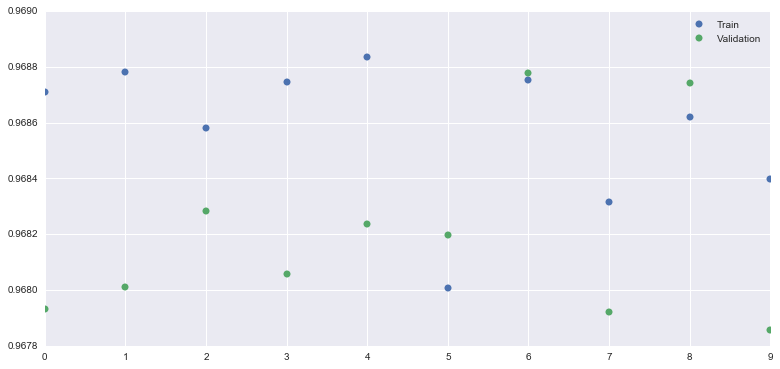

In [11]:
plt.figure(figsize=(13,6))
train_scores = np.zeros(len(models))
val_scores = np.zeros(len(models))
for i in range(len(models)):
    train_scores[i] = metrics.roc_auc_score(Y_test[:N],blend_train[:,i])
    val_scores[i] = metrics.roc_auc_score(Y_test[N:],blend_valid[:,i])
plt.plot(train_scores, 'o', label='Train')
plt.plot(val_scores, 'o', label='Validation')
plt.legend()
plt.show()

# Blend using logistic regression

In [12]:
#blend_use_train = np.array([ bt for (bt, s) in zip(blend_train, train_scores) if s>0.6 ])
#blend_use_test = np.array([ bt for (bt, s) in zip(blend_test, train_scores) if s>0.6 ])
bclf = LogisticRegression()
bclf.fit(blend_train, Y_test[:N])

# Predict now
Y_valid_predict = bclf.predict(blend_test)
score = metrics.roc_auc_score(Y_test[N:], Y_valid_predict)

print('Accuracy = %s' % (score))

ValueError: Found arrays with inconsistent numbers of samples: [  6519 173836]

#### Scores 0.96704 LB using all available models (44 models) accuracy = 0.8525

# Blend using xgb

In [15]:
xg_train = xgb.DMatrix(blend_train, label=Y_test[:N])
xg_valid = xgb.DMatrix(blend_valid, label=Y_test[N:])
xg_test = xgb.DMatrix(blend_test)

watchlist = [(xg_train,'train'), (xg_valid,'test')]
param = {   'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'nthread':3,
            'max_depth':4,
            'colsample_bytree':1.0,
            'subsample':1.0,
            'eta':0.1,
        }
num_round = 1000
bst = xgb.train(param, xg_train, num_round, watchlist, early_stopping_rounds=200)

Will train until test error hasn't decreased in 200 rounds.
[0]	train-auc:0.964688	test-auc:0.955609
[1]	train-auc:0.968605	test-auc:0.958740
[2]	train-auc:0.968983	test-auc:0.959865
[3]	train-auc:0.970690	test-auc:0.961984
[4]	train-auc:0.970843	test-auc:0.961873
[5]	train-auc:0.971385	test-auc:0.961773
[6]	train-auc:0.972159	test-auc:0.961855
[7]	train-auc:0.972523	test-auc:0.961683
[8]	train-auc:0.972706	test-auc:0.961711
[9]	train-auc:0.973019	test-auc:0.961601
[10]	train-auc:0.973189	test-auc:0.961675
[11]	train-auc:0.973557	test-auc:0.961709
[12]	train-auc:0.973466	test-auc:0.961819
[13]	train-auc:0.973504	test-auc:0.962053
[14]	train-auc:0.974447	test-auc:0.962499
[15]	train-auc:0.974592	test-auc:0.962456
[16]	train-auc:0.974933	test-auc:0.962090
[17]	train-auc:0.975036	test-auc:0.962054
[18]	train-auc:0.975007	test-auc:0.962519
[19]	train-auc:0.975026	test-auc:0.962483
[20]	train-auc:0.975985	test-auc:0.964587
[21]	train-auc:0.976094	test-auc:0.964709
[22]	train-auc:0.976383	te

#### Scores 0.96708 LB using highbagging models only (blend auc = 0.96783, individual auc ~0.9668)
#### Scores 0.96705 LB  using all available models unweighted (44 models)
#### Scores 0.96696 LB using 75bag models unweighted 


In [ ]:
pred = bst.predict(xg_test)
#bclf.predict(blend_test)
sample = pd.read_csv('sample_submission.csv')
sample.QuoteConversion_Flag = pred
sample.to_csv('blend_submission_04.csv', index=False)